<a href="https://colab.research.google.com/github/roxacarv/edulearn/blob/main/classifica%C3%A7%C3%A3o/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*texto em itálico*

# Carregamento dos dados

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import datasets
from mlxtend.plotting import plot_decision_regions

dataset = pd.read_csv("dados_ies_sem_nan_utf8.csv", index_col=0, encoding="utf8")
dataset.drop(dataset[dataset.TIPO_CATEGORIA_ADM == "Privada sem fins lucrativos"].index, inplace=True)
dataset.drop(dataset[dataset.TIPO_CATEGORIA_ADM == "Privada com fins lucrativos"].index, inplace=True)

#dataset.dropna(subset=["TIPO_CATEGORIA_ADM"], inplace=True)
#print(set(dataset["TIPO_CATEGORIA_ADM"]))
#dataset.to_csv("dados_ies_sem_nan_sem_privadas_utf8.csv")

# Categorização e mapeamento dos dados de strings para inteiros

In [25]:
from sklearn import preprocessing
from copy import deepcopy

u = deepcopy(dataset)

le = preprocessing.LabelEncoder()

le.fit(dataset["TIPO_CATEGORIA_ADM"])
dataset["TIPO_CATEGORIA_ADM"]=le.transform(dataset["TIPO_CATEGORIA_ADM"])
le_name_mapping_1 = dict(zip(le.classes_, le.transform(le.classes_)))

le.fit(dataset["REGIAO"])
dataset["REGIAO"]=le.transform(dataset["REGIAO"])
le_name_mapping_2 = dict(zip(le.classes_, le.transform(le.classes_)))

le.fit(dataset["UF"])
dataset["UF"]=le.transform(dataset["UF"])
le_name_mapping_3 = dict(zip(le.classes_, le.transform(le.classes_)))

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

import json
a = json.dumps(le_name_mapping_1, default=np_encoder, indent=True, ensure_ascii=False)
b = json.dumps(le_name_mapping_2, default=np_encoder, indent=True, ensure_ascii=False)
c = json.dumps(le_name_mapping_3, default=np_encoder, indent=True, ensure_ascii=False)

ff = '{'
ff += f'\n"TIPO_CATEGORIA_ADM": [\n{a}\n],\n"REGIAO": [\n{b}\n],\n"UF": [\n{c}\n]'
ff += '\n}'

f = open("mapa_categorias.json", "w")
f.write(ff)
f.close()

dataset.to_csv("dados_ies_categorizados.csv")


# Predição do dataset utilizando KNN

Processa células não padronizadas (células vazias)

In [26]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in dataset.columns:
  if dataset[i].dtype == object:
    dataset[i] = le.fit_transform(dataset[i])
  else:
    pass

dataset_encoded = le.fit_transform(dataset.columns)

Normaliza os dados usando StandardScaler e treina o modelo

In [27]:
X = dataset.drop(columns=[
                          "REGIAO", 
                          "TIPO_CATEGORIA_ADM", 
                          "UF", 
                          "CODIGO_IES", 
                          "NUM_CURSOS",
                          "DEFICIENCIA_AUDITIVA",
                          "DEFICIENCIA_VISUAL",
                          "DEFICIENCIA_COGNITIVA",
                          "DEFICIENCIA_MULTIPLA",
                          "RECURSOS_DEF_VISUAL",
                          "RECURSOS_DEF_AUDITIVA",
                          "RECURSOS_DEF_COGNITIVA",
                          "RECURSOS_DEF_MULTIPLA"
                          ])
y = dataset["TIPO_CATEGORIA_ADM"].values

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y=le.transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

Cria o objeto KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [29]:
y_pred

array([2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2,
       2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2,
       1, 2, 2, 1, 2, 2, 1, 2, 2])

Faz a predição

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))
print("Accuracy:\n")
print(accuracy_score(y_test, y_pred))

Confusion matrix:

[[ 0  3  0  0]
 [ 0 33 15  0]
 [ 0  8 32  0]
 [ 0  6  0  0]]

Classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.66      0.69      0.67        48
           2       0.68      0.80      0.74        40
           3       0.00      0.00      0.00         6

    accuracy                           0.67        97
   macro avg       0.34      0.37      0.35        97
weighted avg       0.61      0.67      0.64        97

Accuracy:

0.6701030927835051


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'Mean Error')

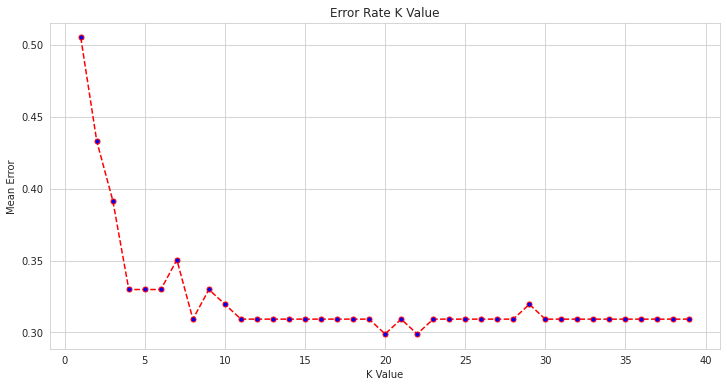

In [31]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=5)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [32]:
X_train

,DEFICIENCIA_FISICA,RECURSOS_DEF_FISICA
267,253.0,1.811321
1736,88.0,4.714286
380,17.0,0.000000
348,16.0,2.200000
2384,1.0,0.000000
...,...,...
42,3.0,4.000000
2079,1.0,0.000000
522,2.0,0.298507
1792,39.0,1.605634


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


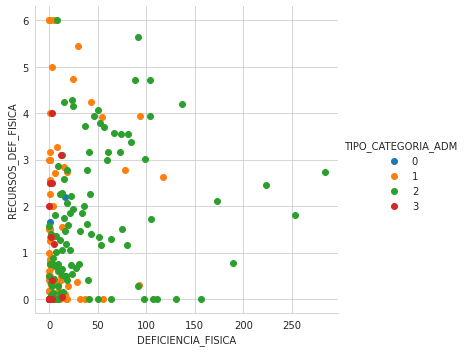

In [33]:
sns.set_style("whitegrid");
sns.FacetGrid(dataset, hue="TIPO_CATEGORIA_ADM", size=5).map(plt.scatter, "DEFICIENCIA_FISICA", "RECURSOS_DEF_FISICA").add_legend();
plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


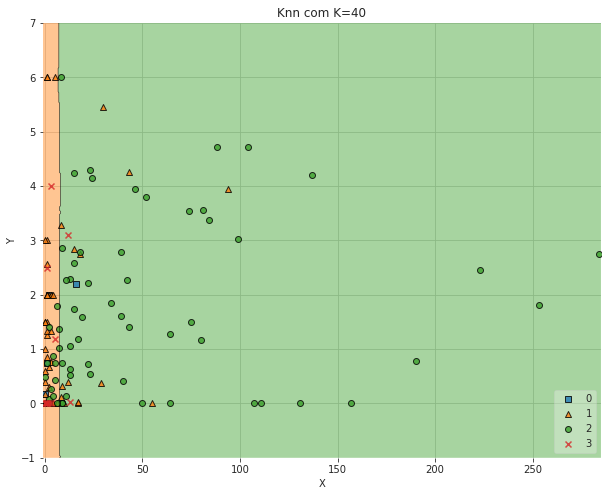

In [34]:

def knn_comparison(X, y, k):
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(X, y)
  value=1.5
  width=0.75
# Plotting decision region
  plt.figure(figsize=(10, 8))
  plot_decision_regions(
     X.to_numpy(), 
     y, 
     clf=clf, 
     legend=4
     )
# Adding axes annotations
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title("Knn com K=" + str(k))
  plt.show()

for i in [40]:
  knn_comparison(X_train, y_train, i)

In [35]:
from sklearn import svm
from sklearn import metrics

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average="weighted"))
print("Recall:",metrics.recall_score(y_test, y_pred, average="weighted"))


Accuracy: 0.6701030927835051
Precision: 0.6266590077697494
Recall: 0.6701030927835051


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
